# Recurrent Neural Network (RNN)

This notebook demonstrates the use of a basic Recurrent Neural Network (RNN) to forecast the next-day **closing price** of Apple stock, using historical daily closing prices as input for sequential trend prediction.

## Importing Libraries

In [1]:
# Data handling
import yfinance as yf
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and scaling
from sklearn.preprocessing import MinMaxScaler

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading and Exploration

In [2]:
# Download Apple stock data
df = yf.download('AAPL', start='2020-07-01', end="2025-06-30", auto_adjust=True)
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-07-01,88.485016,89.274822,88.436417,88.730466,110737200
2020-07-02,88.485016,90.030610,88.370805,89.393906,114041600
2020-07-06,90.852005,91.321027,89.884794,89.916387,118655600
2020-07-07,90.570107,92.011197,90.458321,91.231114,112424400
2020-07-08,92.679512,92.711105,91.461993,91.549483,117092000
...,...,...,...,...,...
2025-06-23,201.500000,202.300003,198.960007,201.630005,55814300
2025-06-24,200.300003,203.440002,200.199997,202.589996,54064000


In [3]:
# Check for missing values
print("Missing values in 'Close' column: \n", df['Close'].isna().sum())

Missing values in 'Close' column: 
 Ticker
AAPL    0
dtype: int64


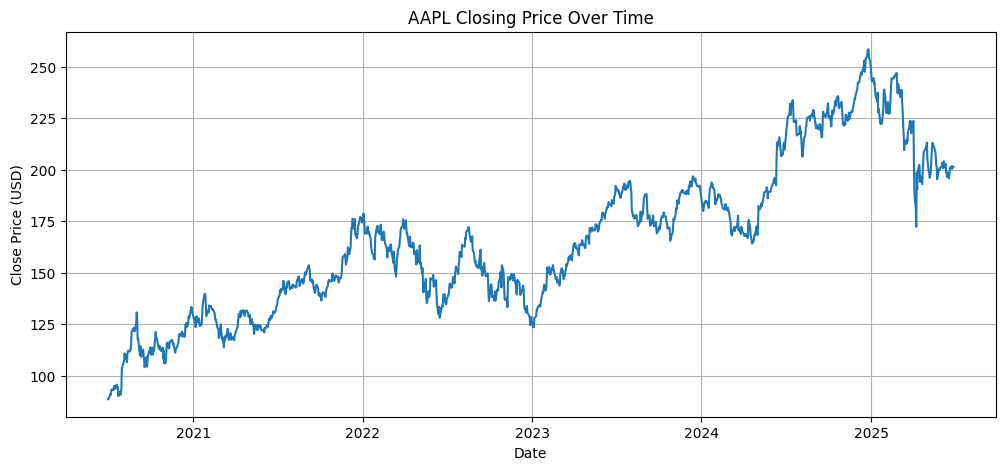

In [4]:
# Plot the closing price over time
plt.figure(figsize=(12, 5))
plt.plot(df['Close'])
plt.title("AAPL Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.grid(True)
plt.show()

## Data Cleaning & Preprocessing

In [5]:
# Drop irrelevant columns
df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df

Price,Close
Ticker,AAPL
Date,
2020-07-01,88.485016
2020-07-02,88.485016
2020-07-06,90.852005
2020-07-07,90.570107
2020-07-08,92.679512
...,...
2025-06-23,201.500000
2025-06-24,200.300003


In [6]:
# Feature scaling
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

# Create time series sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_close, window_size)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1194, 60, 1), y shape: (1194, 1)


In [7]:
# Train/Test split
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## RNN Model: Training and Evaluation

In [8]:
# Build the RNN model
model = Sequential([
    SimpleRNN(units=50, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 3,901
Trainable params: 3,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True, 
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

Epoch 1/50
24/24 [==============================] - 2s 34ms/step - loss: 0.0045 - val_loss: 0.0079
Epoch 2/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0152 - val_loss: 0.0035
Epoch 3/50
24/24 [==============================] - 1s 28ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/50
24/24 [==============================] - 1s 27ms/step - loss: 8.1785e-04 - val_loss: 9.9290e-04
Epoch 5/50
24/24 [==============================] - 1s 28ms/step - loss: 8.7316e-04 - val_loss: 0.0010
Epoch 6/50
24/24 [==============================] - 1s 29ms/step - loss: 7.2683e-04 - val_loss: 7.8375e-04
Epoch 7/50
24/24 [==============================] - 1s 27ms/step - loss: 9.1764e-04 - val_loss: 8.3268e-04
Epoch 8/50
24/24 [==============================] - 1s 29ms/step - loss: 4.5426e-04 - val_loss: 5.6105e-04
Epoch 9/50
24/24 [==============================] - 1s 26ms/step - loss: 4.7863e-04 - val_loss: 5.0706e-04
Epoch 10/50
24/24 [==============================] - 1s 31ms/step

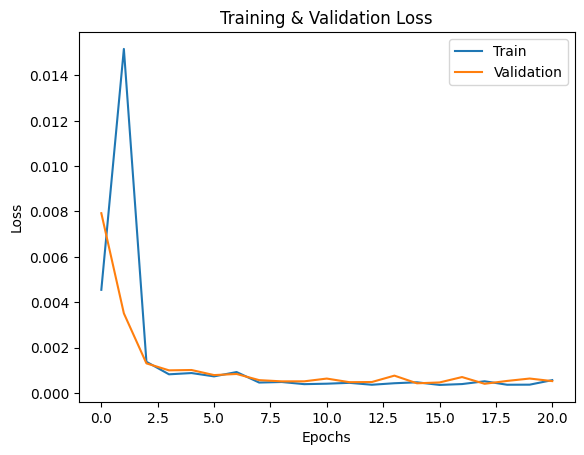

In [10]:
# Plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [11]:
# Predict and inverse scale
predictions = model.predict(X_test)
predicted_close = scaler.inverse_transform(predictions)
actual_close = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 7ms/step


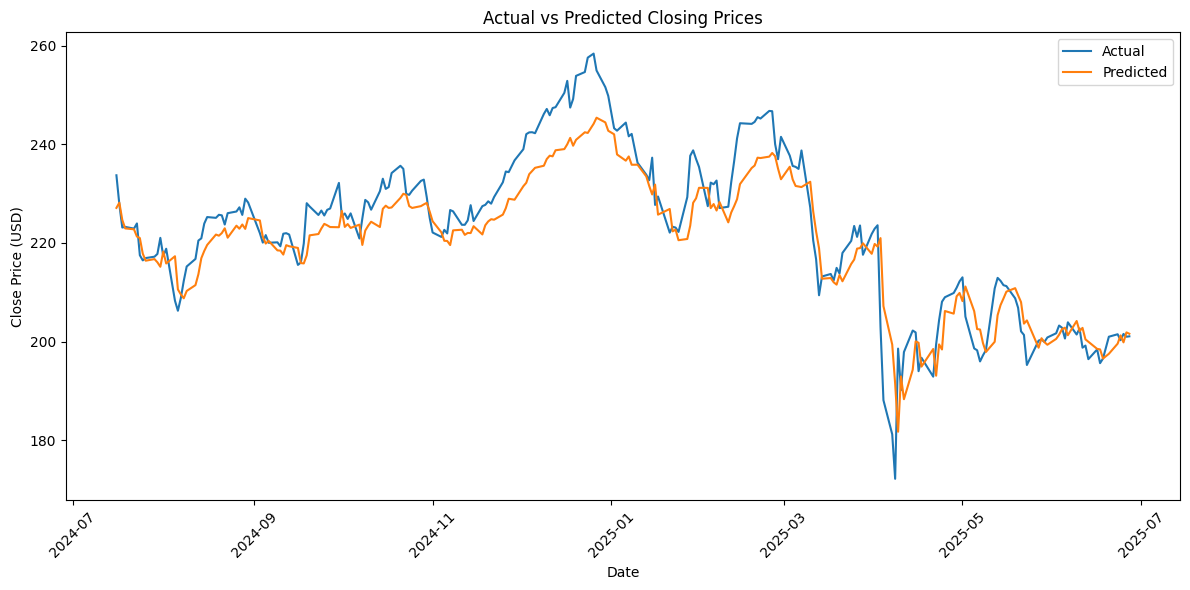

In [12]:
# Select the date range corresponding to the test set
test_dates = df.index[-len(actual_close):]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_close, label='Actual')
plt.plot(test_dates, predicted_close, label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()